In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
from tqdm import tqdm
from scipy.spatial.distance import dice

In [2]:
data_dir = os.path.join(os.getcwd(), 'DATA_TEST')

img_dir = os.path.join(data_dir, '4/images')
mask_dir = os.path.join(data_dir, '4/masks')

IMG_WIDTH, IMG_HEIGHT = 256, 256

In [3]:
X = []

for file in tqdm(os.listdir(img_dir)):
    
    fullpath = os.path.join(img_dir, file)
    img = cv2.imread(fullpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X.append(img)
    
print(img.shape)
X = np.array(X)


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1023.13it/s]


(256, 256, 3)


In [4]:
Y = []

for file in tqdm(os.listdir(mask_dir)):
    
    fullpath = os.path.join(mask_dir, file)
    mat_file =  sio.loadmat(fullpath)
    #get into .mat files
    mat_e= mat_file['E']
    mat_e= mat_e['e']
    mat_arrs = mat_e[0].ravel()
    arrs = mat_arrs[0]
    arr = arrs[0,0]['azs']
    arr = cv2.resize(arr, (IMG_WIDTH, IMG_HEIGHT))
    Y.append(arr)

print(arr.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1643.09it/s]


(256, 256)


In [ ]:
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
import tensorflow as tf

In [6]:
smooth = 1.

#metric function Dice Index - computing similarity between 2 images
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#load learned model from unet.ipynb script
model = load_model('unet.h5', custom_objects={'dice_coef': dice_coef})


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


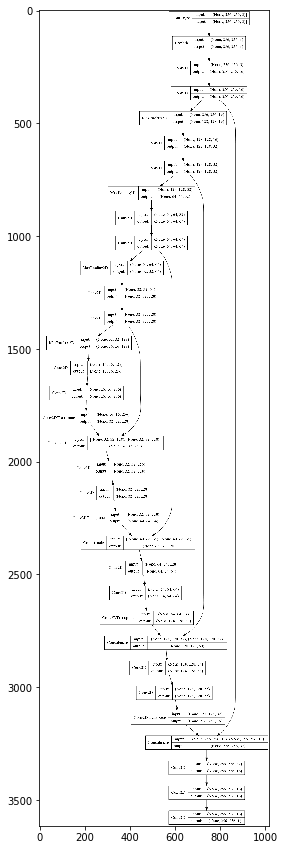

In [7]:
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

#plot network architecture
plot_model(model, show_shapes=True, show_layer_names=False)
import cv2 

img = cv2.imread('model.png',1)
plt.figure(figsize=(30,15))
plt.imshow(img)

In [8]:
datanumber = 70
x = X[datanumber]
print(x.shape)

(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

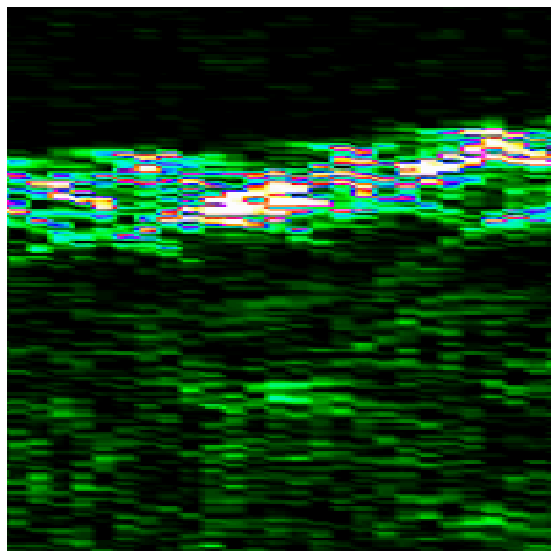

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(x, cmap='gray')
plt.axis('off')


[0.0000000e+00 2.9802322e-08 5.9604645e-08 ... 9.9999923e-01 9.9999928e-01
 9.9999946e-01]
(256, 256)


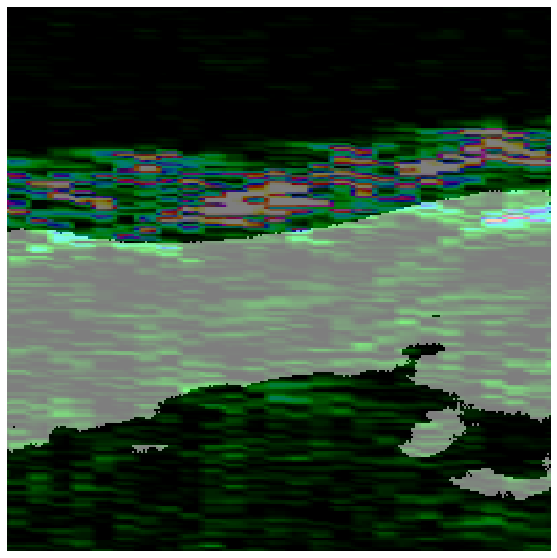

In [10]:
x = x.reshape(1,256,256,3)
pred = model.predict(x)
pred = pred.reshape(256,256)
print(np.unique(pred))

for w in range(0,256):
    for h  in range(0,256):
        
        if pred[w,h] > 0.7: #threshold of propability matrix, range [0,1].
                            #1 is 100% sureness of network pixel belongs to SLEB layer
            pred[w,h] = 1
        else:
            pred[w,h] = 0
            
            
#plot image with printed network output mask
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(pred, cmap='gray', alpha=0.5)
plt.axis('off')

plt.savefig('pred.png', bbox_inches='tight', transparent=True, pad_inches=0)
print(pred.shape)

(256, 256)


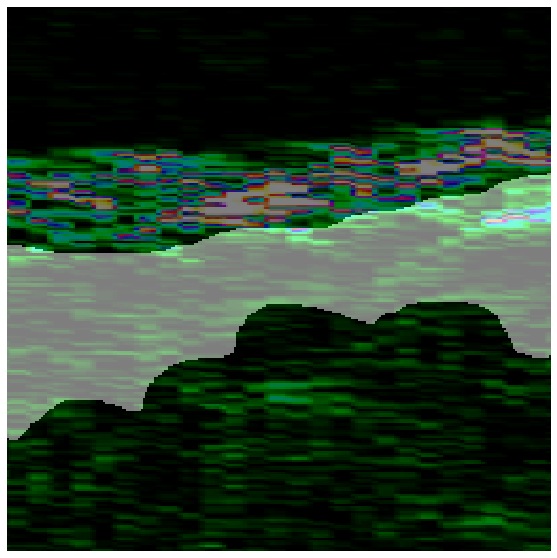

In [11]:
y = Y[datanumber]
print(y.shape)

#plot image with printed expert mask
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(y, cmap='gray', alpha=0.5)
plt.axis('off')
plt.savefig('expert.png', bbox_inches='tight', transparent=True, pad_inches=0)

In [12]:
#compute Dice index
intersection = np.logical_and(pred, y)
dice = 2. * intersection.sum() / (pred.sum() + y.sum())

print(dice)

0.7851807911127888


In [13]:
data_dir = os.path.join(os.getcwd(), 'DATA_TEST')


#results analysis
MEAN_ALL = []
THICK_PREDICTED = []
THICK_EXPERT = []

for k in range(1,13):
    
    THICK_P = 0
    THICK_C = 0
    img_dir = os.path.join(data_dir, '{}/images').format(k)
    mask_dir = os.path.join(data_dir, '{}/masks').format(k)

    IMG_WIDTH, IMG_HEIGHT = 256, 256
    X = []

    for file in tqdm(os.listdir(img_dir)):

        fullpath = os.path.join(img_dir, file)
        img = cv2.imread(fullpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        X.append(img)


    X = np.array(X)

    Y = []

    for file in tqdm(os.listdir(mask_dir)):

        fullpath = os.path.join(mask_dir, file)
        mat_file =  sio.loadmat(fullpath)
        mat_e= mat_file['E']
        mat_e= mat_e['e']
        mat_arrs = mat_e[0].ravel()
        arrs = mat_arrs[0]
        arr = arrs[0,0]['azs']
        arr = cv2.resize(arr, (IMG_WIDTH, IMG_HEIGHT))
        #arr = arr.T
        #img = cv2.flip(arr, 0)    
        Y.append(arr)


    DICE = []
    for j in range(0,100):
        
        img = X[j]
        img = img.reshape(1,256,256,3)
        contour = Y[j]
        pred = model.predict(img)
        pred = pred.reshape(256,256)

        for w in range(0,256):
            for h  in range(0,256):

                if pred[w,h] > 0.5:
                    pred[w,h] = 1
                else:
                    pred[w,h] = 0

        intersection = np.logical_and(pred, contour)

        dice = 2. * intersection.sum() / (pred.sum() + contour.sum())
        DICE.append(dice)
    MEAN = sum(DICE)/len(DICE)
    MEAN_ALL.append(MEAN)
    str = ('dice coefficient for {} dataset with 100 images: {}').format(k,MEAN)
    print(str)

    for w in range(0,256):
        for h  in range(0,256):

            if contour[w,h] == 1:
                THICK_C = THICK_C+1
            if pred[w,h] == 1:
                THICK_P = THICK_P+1
    THICK_PREDICTED.append(THICK_P/256)
    THICK_EXPERT.append(THICK_C/256)

DICE_ALL = sum(MEAN_ALL)/len(MEAN_ALL)


str = 'segmentated area thickness: {}'.format(THICK_PREDICTED)
print(str)

str = 'expert area thickness: {}'.format(THICK_EXPERT)
print(str)

str = 'dice coefficient for whole dataset: {}'.format(DICE_ALL)
print(str)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 183.98it/s]


dice coefficient for 1 dataset with 100 images: 0.8524454637490076


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 276.99it/s]


dice coefficient for 2 dataset with 100 images: 0.8211518505744183


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 275.90it/s]


dice coefficient for 3 dataset with 100 images: 0.8192584281976465


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1618.01it/s]


dice coefficient for 4 dataset with 100 images: 0.8053776335541153


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 292.38it/s]


dice coefficient for 5 dataset with 100 images: 0.8910640570593606


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 274.72it/s]


dice coefficient for 6 dataset with 100 images: 0.8160097301643552


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.58it/s]


dice coefficient for 7 dataset with 100 images: 0.8877614039967006


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 239.96it/s]


dice coefficient for 8 dataset with 100 images: 0.8802317077694981


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 283.72it/s]


dice coefficient for 9 dataset with 100 images: 0.8585219522099301


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 278.34it/s]


dice coefficient for 10 dataset with 100 images: 0.8477951411918202


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.48it/s]


dice coefficient for 11 dataset with 100 images: 0.8991970918864586


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 290.98it/s]


dice coefficient for 12 dataset with 100 images: 0.8799229724399099
segmentated area thickness: [36.17578125, 19.796875, 20.26953125, 78.83203125, 31.46875, 24.4765625, 81.48828125, 39.94140625, 58.8984375, 43.546875, 68.78515625, 30.08984375]
expert area thickness: [37.7890625, 21.8046875, 22.11328125, 65.4453125, 31.27734375, 32.44921875, 65.82421875, 50.81640625, 60.19140625, 42.90625, 69.85546875, 28.10546875]
dice coefficient for whole dataset: 0.8548947860661018


In [14]:
#write full results of test
for l in range(0,12):
    str = 'mean expert area thickness for {} dataset: {} || mean segmentated area thickness for {} dataset: {}'.format((l+1), THICK_EXPERT[l], (l+1), THICK_PREDICTED[l])
    print(str)
print('\n')
for l in range(0,12):
    str = 'dice coefficient for {} dataset (100 images): {}'.format((l+1),MEAN_ALL[l])
    print(str)

print('\n')
str = 'dice coefficient for whole dataset (1200 test images): {}'.format(DICE_ALL)
print(str)

mean expert area thickness for 1 dataset: 37.7890625 || mean segmentated area thickness for 1 dataset: 36.17578125
mean expert area thickness for 2 dataset: 21.8046875 || mean segmentated area thickness for 2 dataset: 19.796875
mean expert area thickness for 3 dataset: 22.11328125 || mean segmentated area thickness for 3 dataset: 20.26953125
mean expert area thickness for 4 dataset: 65.4453125 || mean segmentated area thickness for 4 dataset: 78.83203125
mean expert area thickness for 5 dataset: 31.27734375 || mean segmentated area thickness for 5 dataset: 31.46875
mean expert area thickness for 6 dataset: 32.44921875 || mean segmentated area thickness for 6 dataset: 24.4765625
mean expert area thickness for 7 dataset: 65.82421875 || mean segmentated area thickness for 7 dataset: 81.48828125
mean expert area thickness for 8 dataset: 50.81640625 || mean segmentated area thickness for 8 dataset: 39.94140625
mean expert area thickness for 9 dataset: 60.19140625 || mean segmentated area th